(gallery-misc-field-interpolation)=

# Field Interpolation

There are several reasons for working with field interpolations rather than computing the field on demand.

1. Very large grids take a lot of time to compute, even with Magpylib.
2. The field might not be accessible through Magpylib, e.g. when demagnetization is included, but it can be computed with a 3rd party FE tool or is the result of an experiment.

Combining field interpolation and `CustomSource` enables integration of pre-computed solutions. In the following example we show how this can be done.

## Interpolation

We start by defining a 3D vector-field interpolation function relying on Scipy `RegularGridInterpolator`.

In [1]:
import numpy as np
from scipy.interpolate import RegularGridInterpolator
import magpylib as magpy

def interpolation(observer, data, method="linear", bounds_error=False, fill_value=np.nan):
    """ Creates a 3D-vector field interpolation from regular grid data

    Parameters
    ----------
    observer: ndarray, shape (n,3)
        Array of n position vectors (x,y,z).

    data: ndarray, shape (n,3)
        Array of corresponding n interpolation data vectors.

    method : str, optional
        The method of interpolation to perform. Supported are "linear" and
        "nearest". Default is "linear".

    bounds_error : bool, optional
        If True, when interpolated values are requested outside of the
        domain of the input data, a ValueError is raised. If False,
        then `fill_value` is returned.

    fill_value : number, optional
        Value returned when points outside the interpolation domain are
        sampled.

    Returns
    -------
        callable: interpolating function for field values
    """

    # Condition input
    X, Y, Z = [np.unique(o) for o in observer.T]
    nx, ny, nz = len(X), len(Y), len(Z)

    # Construct interpolations with RegularGridInterpolator for each field component
    rgi = [
        RegularGridInterpolator(
            points=(X, Y, Z),
            values=d.reshape(nx, ny, nz),
            bounds_error=bounds_error,
            fill_value=fill_value,
            method=method,
        )
        for d in data.T]

    # Define field_func usable by Magpylib that returns the interpolation
    def field_func(field, observers):
        return np.array([f(observers) for f in rgi]).T
    return field_func

## CustomSource with Interpolation Field

In the second step we create a custom source with an interpolated field `field_func` input. The data for the interpolation is generated from the Magpylib `Cuboid` field, which makes it easy to verify the approach afterwards. To the custom source a nice 3D model is added that makes it possible to display it and the cuboid at the same time.

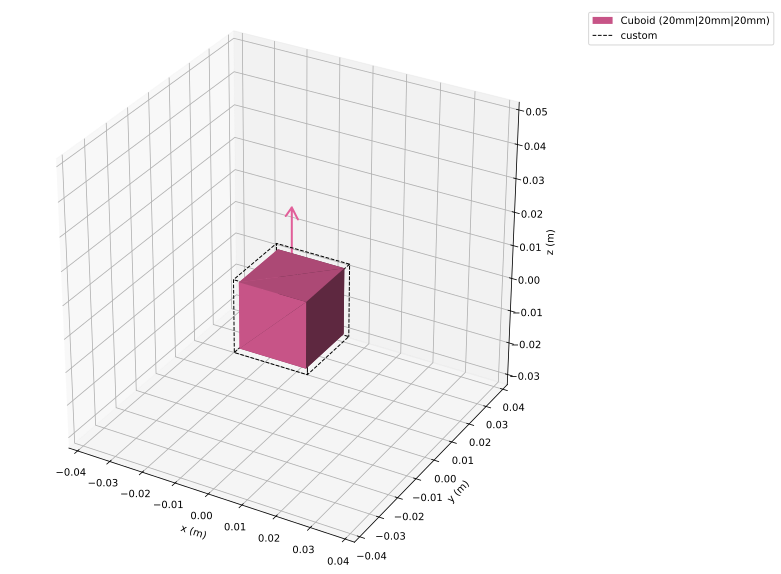

In [2]:
# Create data for interpolation
cube = magpy.magnet.Cuboid(polarization=(0,0,1), dimension=(.02,.02,.02))
ts = np.linspace(-.07, .07, 21)
grid = np.array([(x,y,z) for x in ts for y in ts for z in ts])
data = cube.getB(grid)

# Create custom source with interpolation field
custom = magpy.misc.CustomSource(
    field_func=interpolation(grid, data),
    style_label="custom",
)

# Add nice 3D model (dashed outline) to custom source
xs = 0.011*np.array([-1, -1,  1,  1, -1, -1, -1, -1, -1,  1,  1,  1,  1, 1,  1, -1])
ys = 0.011*np.array([-1,  1,  1, -1, -1, -1,  1,  1,  1,  1,  1,  1, -1, -1, -1, -1])
zs = 0.011*np.array([-1, -1, -1, -1, -1,  1,  1, -1,  1,  1, -1,  1,  1, -1,  1,  1])
trace = dict(
    backend='matplotlib',
    constructor='plot',
    args=(xs, ys, zs),
    kwargs={'ls':'--', 'marker':'', 'lw':1, 'color':'k'},
)
custom.style.model3d.add_trace(trace)
custom.style.model3d.showdefault = False

# Display custom
magpy.show(custom, cube, zoom=1, backend="matplotlib")

## Testing Interpolation Accuracy

Finally, we compare the "exact" field of the cuboid source with the interpolated field of the custom source. For this purpose a sensor is added and a generic rotation is applied to the sources. Naturally there is some error that can be reduced by increasing the interpolation grid finesse.

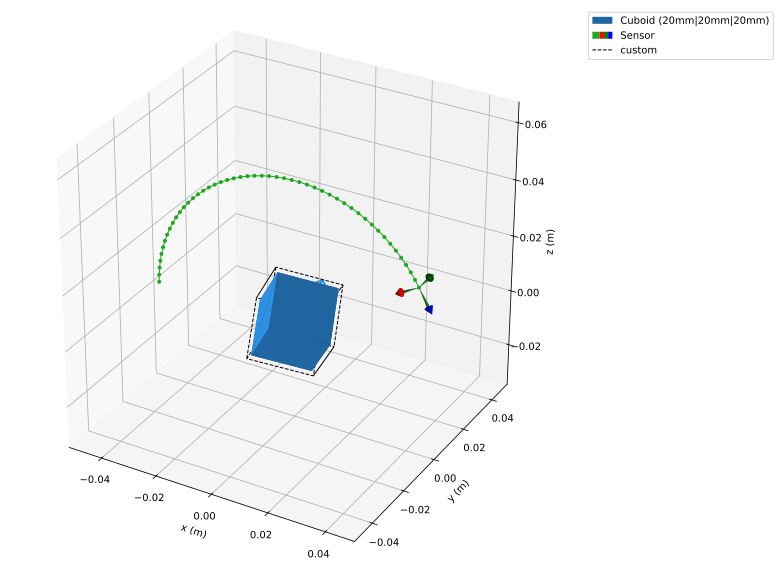

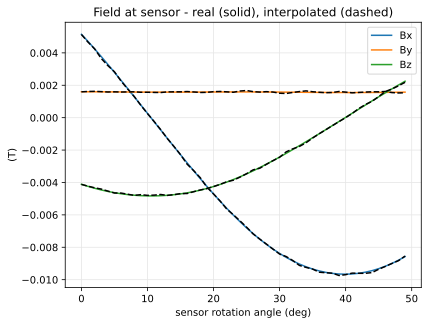

In [3]:
import matplotlib.pyplot as plt

# Modify orientation of cube and custom
for src in [cube, custom]:
    src.rotate_from_angax(angle=45, axis=(1,1,1))

# Add a sensor for testing
sensor = magpy.Sensor(position=(-.05,0,0))
angs = np.linspace(3,150,49)
sensor.rotate_from_angax(angle=angs, axis="y", anchor=0)

# Display system graphically
magpy.show(cube, custom, sensor, backend="matplotlib")

# Create Matplotlib plotting axis
ax = plt.subplot()

# Compute and plot fields
B_cube = cube.getB(sensor)
B_custom = custom.getB(sensor)
for i,lab in enumerate(["Bx", "By", "Bz"]):
    ax.plot(B_cube[:,i], ls="-", label=lab)
    ax.plot(B_custom[:,i], ls="--", color="k")

# Matplotlib figure styling
ax.legend()
ax.grid(color=".9")
ax.set(
    title="Field at sensor - real (solid), interpolated (dashed)",
    xlabel="sensor rotation angle (deg)",
    ylabel="(T)",
)

plt.show()